# Step 04
# Evaluation of performance

In [62]:
%matplotlib inline

In [63]:
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sb

import skimage.io
import skimage.morphology
import skimage.segmentation

import utils.evaluation

### Configuration

In [64]:
from my_config import config_vars

# Partition of the data to make predictions (test or validation)
partition = "validation"

experiment_name = '00'

config_vars = utils.dirtools.setup_experiment(config_vars, experiment_name)

data_partitions = utils.dirtools.read_data_partitions(config_vars)  # read filename list

In [4]:
config_vars

{'root_directory': 'FISH/',
 'max_training_images': 0,
 'create_split_files': True,
 'training_fraction': 0.8,
 'validation_fraction': 0.1,
 'transform_images_to_PNG': True,
 'pixel_depth': 8,
 'min_nucleus_size': 25,
 'boundary_size': 2,
 'augment_images': False,
 'elastic_points': 16,
 'elastic_distortion': 5,
 'elastic_augmentations': 10,
 'learning_rate': 0.0001,
 'epochs': 15,
 'steps_per_epoch': 500,
 'batch_size': 10,
 'val_batch_size': 10,
 'rescale_labels': True,
 'crop_size': 256,
 'cell_min_size': 16,
 'boundary_boost_factor': 1,
 'object_dilation': 3,
 'raw_images_dir': 'FISH/raw_images/',
 'raw_annotations_dir': 'FISH/raw_annotations/',
 'path_files_training': 'FISH/training.txt',
 'path_files_validation': 'FISH/validation.txt',
 'path_files_test': 'FISH/test.txt',
 'normalized_images_dir': 'FISH/norm_images/',
 'boundary_labels_dir': 'FISH/boundary_labels/',
 'experiment_dir': 'FISH/experiments/00/out/',
 'probmap_out_dir': 'FISH/experiments/00/out/prob/',
 'labels_out_di

In [4]:
# To evaluate segmentations produced by other segmentation algorithms (e.g. CellProfiler), 
# manually modify the following config var:

#config_vars["labels_out_dir"] = "/data/cellprofiler_segmentations/"
#config_vars["object_dilation"] = 2

### Auxiliary visualization function

In [65]:
# Display prediction along with segmentation to visualize errors

def show(ground_truth, prediction, threshold=0.5, image_name="N"):
    
    # Compute Intersection over Union
    IOU = utils.evaluation.intersection_over_union(ground_truth, prediction)
    
    # Create diff map
    diff = np.zeros(ground_truth.shape + (3,))  # become 3 channels
    A = ground_truth.copy()
    B = prediction.copy()
    A[A > 0] = 1
    B[B > 0] = 1
    D = A - B
    #diff[D > 0,:2] = 1
    #diff[D < 0,1:] = 1
    
    # Object-level errors
    C = IOU.copy()
    C[C>=threshold] = 1
    C[C<threshold] = 0
    missed = np.where(np.sum(C,axis=1) == 0)[0]
    extra = np.where(np.sum(C,axis=0) == 0)[0]

    for m in missed:
        diff[ground_truth == m+1, 0] = 1
    for e in extra:
        diff[prediction == e+1, 2] = 1
    
    # Display figures
    fig, ax = plt.subplots(1, 4, figsize=(18,6))
    ax[0].imshow(ground_truth)
    ax[0].set_title("True objects:"+str(len(np.unique(ground_truth))))
    ax[1].imshow(diff)
    ax[1].set_title("Segmentation errors:"+str(len(missed)))
    ax[2].imshow(prediction)
    ax[2].set_title("Predicted objects:"+str(len(np.unique(prediction))))
    ax[3].imshow(IOU)
    ax[3].set_title(image_name)

### Run the evaluation
Predictions are the ones stored in Step 03 and loaded here for evaluation calculations  
label the ground truth(raw annotations) and compare with the predicted labels

/home/lanbowen23/Instance/unet4nuclei/unet4nuclei/utils/evaluation.py:92: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  results = pd.concat([results, pd.DataFrame(data=data.T, columns=["Area", "False_Negative"])])


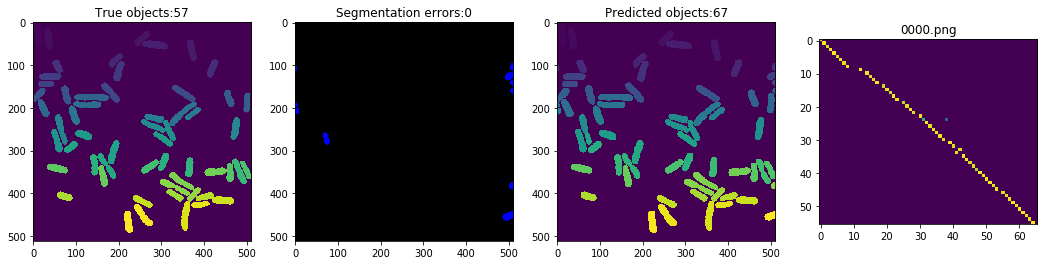

In [66]:
all_images = data_partitions[partition]  # validation

results = pd.DataFrame(columns=["Image", "Threshold", "F1", "Jaccard", "TP", "FP", "FN"])
false_negatives = pd.DataFrame(columns=["False_Negative", "Area"])
splits_merges = pd.DataFrame(columns=["Image_Name", "Merges", "Splits"])

for image_name in all_images:
    # Load ground truth data
    img_filename = os.path.join(config_vars["raw_annotations_dir"], image_name)
    ground_truth = skimage.io.imread(img_filename)
    if len(ground_truth.shape) == 3:
        ground_truth = ground_truth[:,:,0]
    
    # Transform to label matrix
    ground_truth = skimage.morphology.label(ground_truth)
    
    # Load predictions
    pred_filename = os.path.join(config_vars["labels_out_dir"], image_name)
#     prediction = skimage.io.imread(pred_filename.replace(".png",".tif"))
    prediction = skimage.io.imread(pred_filename)

    
    # Apply object dilation
    if config_vars["object_dilation"] > 0:
        struct = skimage.morphology.square(config_vars["object_dilation"])
        prediction = skimage.morphology.dilation(prediction, struct)
    elif config_vars["object_dilation"] < 0:
        struct = skimage.morphology.square(-config_vars["object_dilation"])
        prediction = skimage.morphology.erosion(prediction, struct)
        
    # Relabel objects (cut margin of 30 pixels to make a fair comparison with DeepCell)
    ground_truth = skimage.segmentation.relabel_sequential(ground_truth)[0] #[30:-30,30:-30])[0]
    prediction = skimage.segmentation.relabel_sequential(prediction)[0] #[30:-30,30:-30])[0]
    
    # Compute evaluation metrics
    # Add result into pd dataframe one by one
    results = utils.evaluation.compute_af1_results(
        ground_truth, 
        prediction, 
        results, 
        image_name
    )
    
    false_negatives = utils.evaluation.get_false_negatives(
        ground_truth, 
        prediction, 
        false_negatives, 
        image_name
    )
    
    splits_merges = utils.evaluation.get_splits_and_merges(
        ground_truth, 
        prediction, 
        splits_merges, 
        image_name
    )
    
    # Display an example image
    if image_name == all_images[0]:
        show(ground_truth, prediction, image_name=image_name)

#### show the comparison between norm_image, raw_annot and label_out

In [17]:
import matplotlib as mpl
mpl.rcParams["image.cmap"] # default to viridis

'viridis'

In [49]:
mpl.rcParams["image.cmap"] = 'viridis'

In [56]:
img_name = "0000.png"
pred_label_filename = os.path.join(config_vars["labels_out_dir"], img_name)
pred_label = skimage.io.imread(pred_label_filename)
pred_label = skimage.segmentation.relabel_sequential(pred_label)[0]

inc = lambda x: x if x == 0 else x + 100
inc = np.vectorize(inc)  # this is implemented by for loop
pred_label = inc(pred_label)
print(type(pred_label))
pred_label.min()

<class 'numpy.ndarray'>


0

In [59]:
def compare(img_name):
    ori_img_filename = os.path.join(config_vars["normalized_images_dir"], img_name)
    original_image = skimage.io.imread(ori_img_filename)
    annot_filename = os.path.join(config_vars["raw_annotations_dir"], img_name)
    raw_label = skimage.io.imread(annot_filename)
    pred_label_filename = os.path.join(config_vars["labels_out_dir"], img_name)
    pred_label = skimage.io.imread(pred_label_filename)

    raw_label = skimage.morphology.label(raw_label)
    raw_label = skimage.segmentation.relabel_sequential(raw_label)[0] #[30:-30,30:-30])[0]
    
    struct = skimage.morphology.square(config_vars["object_dilation"])
    pred_label = skimage.morphology.dilation(pred_label, struct)
    pred_label = skimage.segmentation.relabel_sequential(pred_label)[0] #[30:-30,30:-30])[0]
    
    inc = lambda x: x if x == 0 else x + 100
    inc = np.vectorize(inc)
    raw_label = inc(raw_label)
    pred_label = inc(pred_label)
    
    fig, ax = plt.subplots(1, 3, figsize=(15,5))
    fig.suptitle(img_name)
    ax[0].set_title("original image")
    ax[0].imshow(original_image)
    ax[1].set_title("raw label")
    ax[1].imshow(raw_label)
    ax[2].set_title("predicted label")
    ax[2].imshow(pred_label)


    # plt.figure(figsize=(6,6))
    # plt.imshow(original_image)  #, cmap="nipy_spectral")
    # plt.show()

In [ ]:
for i in np.random.randint(48, size = 5):
    img = "{:04}".format(i) + ".png"
    compare(img)

#### 探究IOU的计算方式

In [63]:
image_name = all_images[0]
img_filename = os.path.join(config_vars["raw_annotations_dir"], image_name)
ground_truth = skimage.io.imread(img_filename)
if len(ground_truth.shape) == 3:
    ground_truth = ground_truth[:,:,0]
    
# Transform to label matrix
ground_truth = skimage.morphology.label(ground_truth)

# Load predictions
pred_filename = os.path.join(config_vars["labels_out_dir"], image_name)
#     prediction = skimage.io.imread(pred_filename.replace(".png",".tif"))
prediction = skimage.io.imread(pred_filename)

# 可能是想要更平滑
# Apply object dilation
if config_vars["object_dilation"] > 0:
    struct = skimage.morphology.square(config_vars["object_dilation"])
    prediction = skimage.morphology.dilation(prediction, struct)
elif config_vars["object_dilation"] < 0:
    struct = skimage.morphology.square(-config_vars["object_dilation"])
    prediction = skimage.morphology.erosion(prediction, struct)

# Relabel objects (cut margin of 30 pixels to make a fair comparison with DeepCell)
ground_truth = skimage.segmentation.relabel_sequential(ground_truth)[0] #[30:-30,30:-30])[0]
prediction = skimage.segmentation.relabel_sequential(prediction)[0] #[30:-30,30:-30])[0]

In [64]:
true_objects = len(np.unique(ground_truth))
pred_objects = len(np.unique(prediction))

# Compute intersection
h = np.histogram2d(ground_truth.flatten(), prediction.flatten(), bins=(true_objects, pred_objects))
intersection = h[0]
np.where(intersection == 0)

(array([ 1,  1,  1, ..., 56, 56, 56]), array([ 0,  2,  3, ..., 62, 63, 65]))

In [65]:
intersection[1, 0]

0.0

In [66]:
# Area of objects
area_true = np.histogram(ground_truth, bins=true_objects)[0]
area_pred = np.histogram(prediction, bins=pred_objects)[0]
area_true = np.expand_dims(area_true, -1)
area_pred = np.expand_dims(area_pred, 0)

In [67]:
union = area_true + area_pred - intersection
union.shape

(57, 66)

In [68]:
# Exclude background from the analysis
intersection = intersection[1:, 1:]
union = union[1:, 1:]

# Compute Intersection over Union
union[union == 0] = 1e-9
IOU = intersection / union

IOU.shape

(56, 65)

### Report of results

In [67]:
# Display accuracy results
# 在以相同Threshold为一组中取另外columns的平均值

average_performance = results.groupby("Threshold").mean().reset_index()
average_performance

,Threshold,F1,Jaccard
0,0.50,0.880331,0.748379
1,0.55,0.870486,0.748379
2,0.60,0.866145,0.748379
3,0.65,0.864357,0.748379
4,0.70,0.861972,0.748379
5,0.75,0.858966,0.748379
6,0.80,0.848584,0.748379
7,0.85,0.796755,0.748379
8,0.90,0.748593,0.748379
9,0.95,0.380172,0.748379


In [69]:
R = results.groupby("Image").mean().reset_index()
R.sort_values(by="F1", ascending=False).loc[12, "Image"]  
# R

'0012.png'

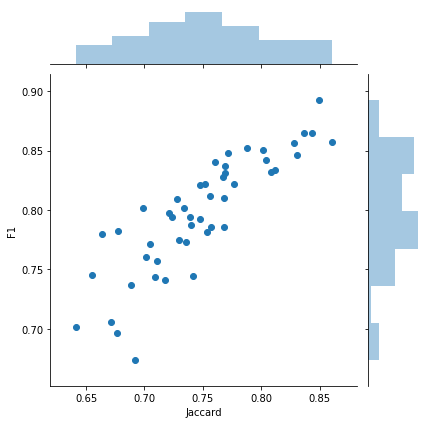

In [70]:
g = sb.jointplot(data=R[R["F1"] > 0.4], x="Jaccard", y="F1")

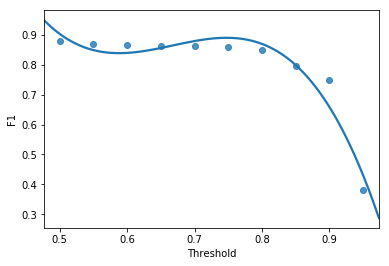

In [71]:
# Plot accuracy results

sb.regplot(data=average_performance, x="Threshold", y="F1", order=3, ci=None)

In [72]:
# Compute and print Average F1

average_F1_score = average_performance["F1"].mean()
jaccard_index = average_performance["Jaccard"].mean()
print("Average F1 score:", average_F1_score)
print("Jaccard index:", jaccard_index)

Average F1 score: 0.7976362157346384
Jaccard index: 0.7483787586141927


In [74]:
# Summarize False Negatives by area

false_negatives = false_negatives[false_negatives["False_Negative"] == 1]

false_negatives.groupby(
    pd.cut(
        false_negatives["Area"], 
        [0,250,625,900,10000], # Area intervals
        labels=["Tiny nuclei","Small nuclei","Normal nuclei","Large nuclei"],
    )
)["False_Negative"].sum()

Area
Tiny nuclei       NaN
Small nuclei     26.0
Normal nuclei    14.0
Large nuclei     57.0
Name: False_Negative, dtype: float64

In [75]:
# Summarize splits and merges

print("Splits:",np.sum(splits_merges["Splits"]))
print("Merges:",np.sum(splits_merges["Merges"]))

Splits: 66
Merges: 5


In [76]:
# Report false positives

print("Extra objects (false postives):",results[results["Threshold"].round(3) == 0.7].sum()["FP"])

Extra objects (false postives): 910
